In [133]:
import pandas as pd
from pandas_ods_reader import read_ods
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

In [134]:
target = 'SOIL_CO2_FLUX'

In [135]:
# loads all data sets into a dict
def load_datasets(dirs: list) -> dict:
    file_names = ['flux_soc_out', 'atmosphere_out', 'n_flux_out', 'p_flux_out', 'soil_c_out', 'soil_water_out', 'surf_water_out', 'temp_out']
    datasets = {}
    for dr in dirs:
        path = 'datasets/' + dr + '/daily_data_merged'
        flux_soc = pd.read_csv(os.path.join(path, file_names[0] + '.csv'))
        atm = pd.read_csv(os.path.join(path, file_names[1] + '.csv'))
        nitrogen = pd.read_csv(os.path.join(path, file_names[2] + '.csv'))
        phosp = pd.read_csv(os.path.join(path, file_names[3] + '.csv'))
        soil_carbon = pd.read_csv(os.path.join(path, file_names[4] + '.csv'))
        soil_water = pd.read_csv(os.path.join(path, file_names[5] + '.csv'))
        surf_water = pd.read_csv(os.path.join(path, file_names[6] + '.csv'))
        temp = pd.read_csv(os.path.join(path, file_names[7] + '.csv'))

        flux_soc = flux_soc.drop(flux_soc.columns[0], axis=1)
        atm = atm.drop(atm.columns[0], axis=1)
        nitrogen = nitrogen.drop(nitrogen.columns[0], axis=1)
        phosp = phosp.drop(phosp.columns[0], axis=1)
        soil_carbon = soil_carbon.drop(soil_carbon.columns[0], axis=1)
        soil_water = soil_water.drop(soil_water.columns[0], axis=1)
        surf_water = surf_water.drop(surf_water.columns[0], axis=1)
        temp = temp.drop(temp.columns[0], axis=1)

        csv_list = [flux_soc, atm, nitrogen, phosp, soil_carbon, soil_water, surf_water, temp]

        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[file_names[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']
datasets = load_datasets(dirs)

In [136]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df
# turn all csv's to one dataframe

def to_pd(df: dict, handle_dupes: bool) -> pd.DataFrame:
    dup_cols = ['ICE_13','WTR_5','SEDIMENT','WTR_8','WTR_7','ACTV_LYR','WTR_TBL','WTR_6','WTR_4','ICE_7','WTR_3','WTR_2','WTR_1','SNOWPACK','DISCHG','RUNOFF','WTR_9','WTR_10','WTR_11','WTR_12','WTR_13','SURF_WTR','ICE_1','ICE_2','ICE_3','ICE_4','ICE_5','SURF_ICE','ICE_6','ICE_12','ICE_11','ICE_10','ICE_9','PRECN','WIND','ICE_8','O2_FLUX','CH4_FLUX']
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
        
        if handle_dupes:
            dupes = [col for col in cur.columns if col in dup_cols]
            
            if file_name == 'soil_water_out' or file_name == 'flux_soc_out':
                cur = rename_dupes('_SOIL', cur, dupes)
            elif file_name == 'surf_water_out':
                cur = rename_dupes('_SURF', cur, dupes)
            elif file_name == 'atmosphere_out':
                cur = rename_dupes('_ATM', cur, dupes)
            
        x = pd.concat([x, df[file_name]], axis = 1)
    x = x.drop(['DATE', 'unnamed.1'], axis=1)

    return x

x = to_pd(datasets['warm_temp_maize_soybean_irrigated'], True)
y = x[target].copy()
x = x.drop(target,axis = 1)

CO2_FLUX LINEAR CORRELATED FEATURES

In [ ]:
irrigated_df = datasets['warm_temp_maize_soybean_irrigated']
features = {
'ECO_NPP' : irrigated_df['flux_soc_out']['ECO_NPP'],
'ECO_GPP' : irrigated_df['flux_soc_out']['ECO_GPP'],
'PRECN' : irrigated_df['soil_water_out']['PRECN'] ,
'SUB_DOP_FLX' : irrigated_df['p_flux_out']['SUB_DOP_FLX'] ,
'ECO_RA' : irrigated_df['flux_soc_out']['ECO_RA'] ,
'N2_FLUX' : irrigated_df['n_flux_out']['N2_FLUX'] ,
'N2O_FLUX': irrigated_df['n_flux_out']['N2O_FLUX'] ,
}

x = pd.DataFrame(features)
y = irrigated_df['flux_soc_out']['CO2_FLUX']

NBP LINEAR CORRELATED FEATURES

In [115]:
nbp_feats = {
'ECO_NPP': irrigated_df['flux_soc_out']['ECO_NPP'],       
'ECO_GPP': irrigated_df['flux_soc_out']['ECO_GPP'],         
'NET_N_MIN': irrigated_df['n_flux_out']['NET_N_MIN'],      
'PRECN': irrigated_df['n_flux_out']['NET_N_MIN'],             
'NET_P_MIN': irrigated_df['p_flux_out']['NET_P_MIN'],      
'SUB_DOP_FLX': irrigated_df['p_flux_out']['SUB_DOP_FLX'],     
'ET': irrigated_df['soil_water_out']['ET'],
'DISCHG_SOIL': irrigated_df['soil_water_out']['DISCHG'],    
'DISCHG_SURF': irrigated_df['surf_water_out']['DISCHG'],    
'FERTZR_P':  irrigated_df['p_flux_out']['FERTZR_P'],          
'FERTZR_N':   irrigated_df['n_flux_out']['FERTZR_N'],           
'H2_FLUX':  irrigated_df['flux_soc_out']['H2_FLUX'],             
'NET_PL_EXCH_N':  irrigated_df['n_flux_out']['NET_PL_EXCH_N'],           
'N2O_FLUX': irrigated_df['n_flux_out']['N2O_FLUX'],
'N2_FLUX': irrigated_df['n_flux_out']['N2_FLUX'],
'ECO_RA': irrigated_df['flux_soc_out']['ECO_RA']
}

x = pd.DataFrame(nbp_feats)
y = irrigated_df['flux_soc_out']['NBP']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=42)

In [138]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

In [139]:
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [140]:
# Predict the model
pred = xgb_r.predict(X_test)
  

RMSE :  0.351103


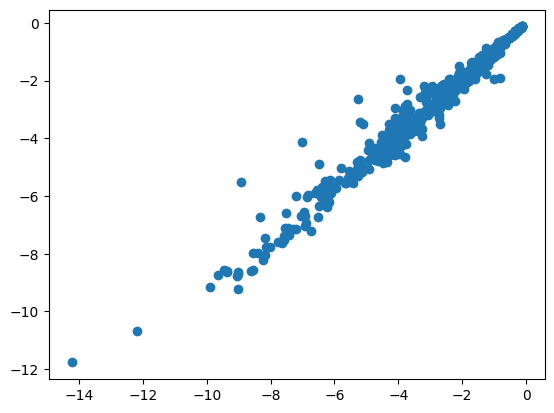

In [141]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))
plt.scatter(y_test, pred)

In [142]:
importances = pd.DataFrame({'GINI': xgb_r.feature_importances_}, index=x.columns).sort_values(by='GINI', ascending=False)

In [143]:
g = importances[importances > 0].dropna()

In [144]:
g

,GINI
O2_FLUX,0.426107
TMAX_SOIL_3,0.151590
SUB_DOP_FLX,0.094021
CO2_LIT,0.021613
CH4_1,0.019768
...,...
SOL_RADN,0.000043
SOC_12,0.000037
CH4_FLUX_SOIL,0.000023
WIND_ATM,0.000022


In [145]:
os.makedirs('feature_analysis/xgboost', exist_ok=True)  
g.to_csv('feature_analysis/xgboost/FeaturesImportance' + target + '.csv')  